# Home Assignment No. 3 ( Practice)

# GLM: 1st-level Analysis

* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/), [sklearn](https://scikit-learn.org/stable/) and [pytorch](https://pytorch.org/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` and `pytorch` libraries, as well as ready **NN BUILDING BLOCKS** from `pytorch.nn` module, instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE SCORES**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

### Let's do fMRI classical GLM analysis for the  `overt verb generation` task 

You will find `###TODO` at the places where you should add code.

The notebooks from `Seminar4` will help you to complete the tasks: https://github.com/adasegroup/NEUROML2021/tree/master/seminar4

#### To get maximum points in the first part you are to:

1. Setup the design Matrix **(2 points)**

2. Setup a t-test  **(2 points)**

3. Plot statistical maps at different thresholds **(2 points)**

4. In this part, we ask you to write a detailed report about what you did and what you got. The previous sections practically repeat the seminar, but often reproducing ready-made examples, we lose sight of the heart of the matter. So this task will encourage you to focus on the deeper understanding of your steps in the first place, which is what we expect from you in this course. **(4 points)**

# 1st Leval Analysis in Nipype (3 points)

In [39]:
import pandas as pd
import os

from nilearn import plotting
%matplotlib inline


from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node

import sys
sys.path.append('/home/neuro/nipype_tutorial/notebooks/seminar/')
from utils import list_files

Find out a correct TR of image sequences (3 points):

In [41]:
# specify paths
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
# Repetition time(TR) of functional images
###TODO:
#ADD CORRECT TR
import json
with open('/data/ds000114/task-overtverbgeneration_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']
num_dummies = 4

In [97]:
!ls /output/workingdir/preproc/_subject_id_01_task_name_overtverbgeneration

art  extract  _fwhm_5  _fwhm_8	mcflirt  selectfiles  slicetimer


In [67]:
print(f'TR={TR} num_dummies={num_dummies}')

TR=5.0 num_dummies=4


## Prepare design matrix
Let's take a look how the stimuli onset and duration look like.This information is store in a ``tsv`` file. 

In [42]:
trialinfo = pd.read_table('/data/ds000114/task-overtverbgeneration_events.tsv')
trialinfo

,onset,duration,weight,trial_type
0,20,30.0,1,Task
1,80,30.0,1,Task
2,140,30.0,1,Task
3,200,30.0,1,Task
4,260,30.0,1,Task
5,320,30.0,1,Task
6,380,30.0,1,Task


In [68]:
###TODO:
#Create a node 'getsubjectinfo' that will get subject specific condition information(used to build the design matrix) 
#HINT: append the onset with the wright shift
#HINT: the shift is needed, becouse we skipped dummy scans with the 'extract' NODE

def subjectinfo(subject_id):
    import pandas as pd
    from nipype.interfaces.base import Bunch

    
    trialinfo = pd.read_table('/data/ds000114/task-covertverbgeneration_events.tsv')
    #trialinfo.head()
    conditions = []
    onsets = []
    durations = []
    shift = 5*4# TR*num_dummies

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - shift))
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

## Initiate Nodes

In [69]:
# SpecifyModel - Generates SPM-specific Model
#Setup
#https://nipype.readthedocs.io/en/latest/api/generated/nipype.algorithms.modelgen.html#specifymodel
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
#https://www.fil.ion.ucl.ac.uk/spm/doc/manual.pdf#page=59
#hrf- Name of basis function(canonical)
#'derivs': [1, 0]-Time derivatives : Time and Dispersion

#model_serial_correlations-serial correlations using an autoregressive estimator (order 1)

level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
#https://www.fil.ion.ucl.ac.uk/spm/doc/manual.pdf#page=69

level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

## Specify contrasts
We are gona perform one T test. Recall the general form of the hypothesis are

$$\sum \limits _{i=1} ^{N} c_{i}{\beta}_{i} > 0 $$

In [70]:
###TODO: Add a t-test for Ho c1>0.
#HINT: We have only one c. Notice node infosource.
# Condition names
import numpy as np
conditions = list(np.unique(trialinfo.trial_type))

# Contrasts
# contrast =  [<contrast_name>, <test>, <condition_names>, <[c1, c2, c3]>]
cont01 = ['activation',     'T', conditions, [1]] # betta > 0
cont02 = ['deactivation',   'T', conditions, [-1]] # betta < 0
# no need to test other conditions as they will only multiply existing contrasts by some value

contrast_list = [cont01, cont02]

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [71]:
#Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {
        'func': 'datasink/preproc/sub-{subject_id}/task-{task_id}/fwhm-5_ssub-{subject_id}_ses-test_task-{task_id}_bold.nii',
        'mc_param': 'datasink/preproc/sub-{subject_id}/task-{task_id}/sub-{subject_id}_ses-test_task-{task_id}_bold.par',
        'outliers': 'datasink/preproc/sub-{subject_id}/task-{task_id}/art.sub-{subject_id}_ses-test_task-{task_id}_bold_outliers.txt'
    }
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

###TODO: CHANGE THE task_id
selectfiles.inputs.task_id = 'overtverbgeneration'


# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and **connect** the interface nodes and the I/O stream to each other.

In [72]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = f'{experiment_dir}/{working_dir}'

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

## Visualize the workflow

221020-17:59:02,949 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


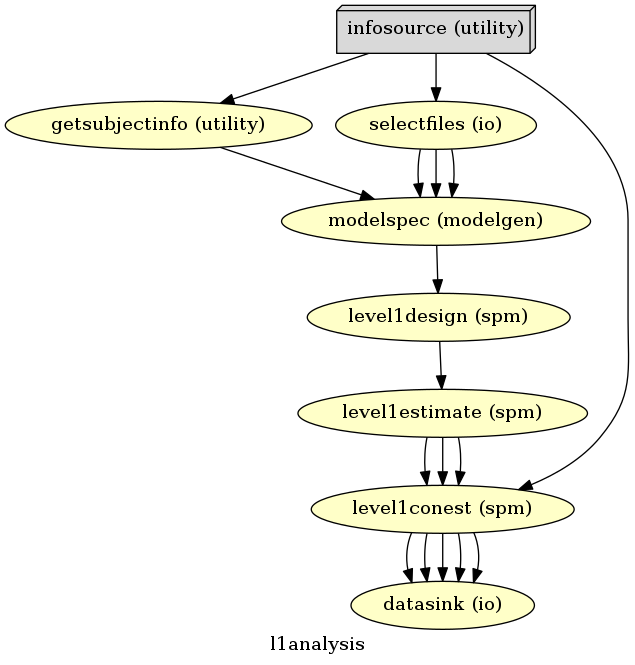

In [73]:
# Save the 1st-level analysis graph as png
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=f'{l1analysis.base_dir}/l1analysis/graph.png')

221020-17:59:04,350 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.png (graph2use=flat, simple_form=True).


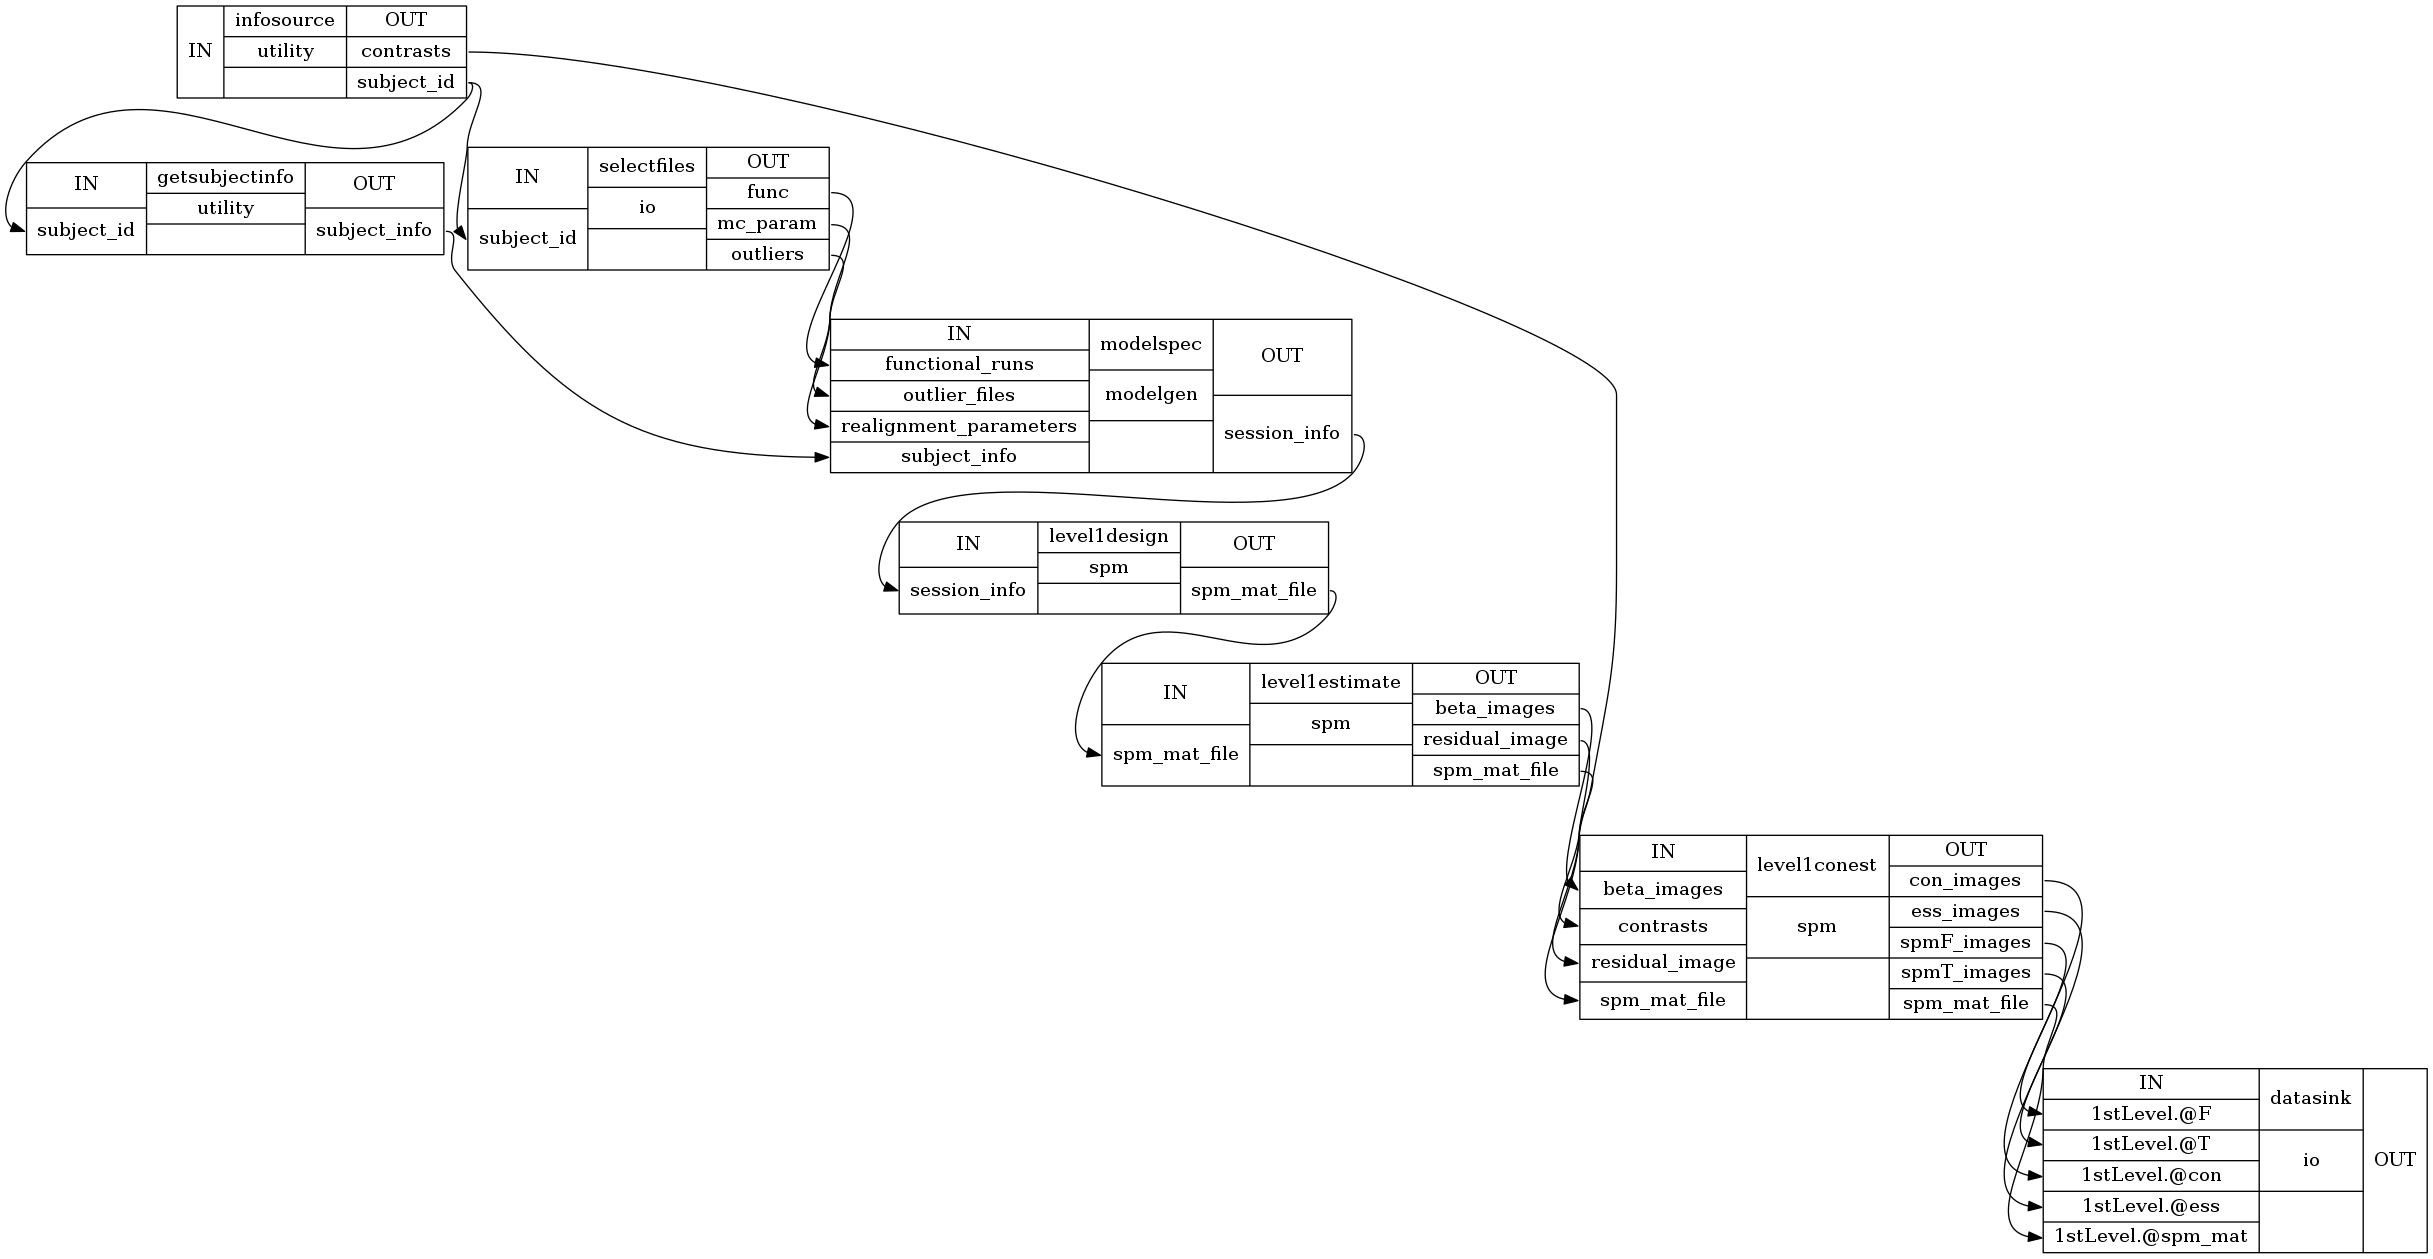

In [74]:
# show detailed workflow
l1analysis.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=f'{l1analysis.base_dir}/l1analysis/graph_detailed.png')

##  Run the Workflow

Run the 1st-level analysis workflow.

In [75]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

221020-17:59:04,423 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
221020-17:59:04,509 nipype.workflow INFO:
	 Running in parallel.
221020-17:59:04,514 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 20 jobs ready. Free memory (GB): 226.64/226.64, Free processors: 4/4.
221020-17:59:04,889 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_10/getsubjectinfo".221020-17:59:04,891 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_09/getsubjectinfo".221020-17:59:04,891 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_09/selectfiles".221020-17:59:04,890 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_10/selectfiles".



221020-17:59:04,900 nipype.workflow INFO:
	 [Node] Run

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_subject_id_09/modelspec/art.sub-09_ses-test_task-overtverbgeneration_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


221020-17:59:06,912 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
221020-17:59:06,922 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".221020-17:59:06,922 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".

221020-17:59:06,931 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
221020-17:59:08,517 nipype.workflow INFO:
	 [Job 2] Completed (l1analysis.modelspec).
221020-17:59:08,519 nipype.workflow INFO:
	 [Job 9] Completed (l1analysis.modelspec).
221020-17:59:08,521 nipype.workflow INFO:
	 [Job 14] Completed (l1analysis.getsubjectinfo).
221020-17:59:08,523 nipype.workflow INFO:
	 [Job 15] Completed (l1analysis.selectfiles).
221020-17:59:08,526 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 17 jobs ready. Free memory (GB): 226.64/226.64, Free processors: 4/4.
221020-17:59:08,908 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_10/level1design".221020

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_subject_id_08/modelspec/art.sub-08_ses-test_task-overtverbgeneration_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


221020-17:59:08,944 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
221020-17:59:08,949 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")221020-17:59:08,950 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".

221020-17:59:08,966 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
221020-17:59:10,518 nipype.workflow INFO:
	 [Job 16] Completed (l1analysis.modelspec).
221020-17:59:10,520 nipype.workflow INFO:
	 [Job 21] Completed (l1analysis.getsubjectinfo).
221020-17:59:10,523 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 14 jobs ready. Free memory (GB): 226.24/226.64, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
221020-17:59:10,870 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_su

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_subject_id_05/modelspec/art.sub-05_ses-test_task-overtverbgeneration_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


221020-17:59:52,917 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
221020-17:59:52,931 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
221020-17:59:52,933 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
221020-17:59:54,553 nipype.workflow INFO:
	 [Job 26] Completed (l1analysis.level1conest).
221020-17:59:54,555 nipype.workflow INFO:
	 [Job 37] Completed (l1analysis.modelspec).
221020-17:59:54,557 nipype.workflow INFO:
	 [Job 42] Completed (l1analysis.getsubjectinfo).
221020-17:59:54,559 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 9 jobs ready. Free memory (GB): 226.44/226.64, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1design
221020-17:59:54,942 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_07/datasink".221020-17:59:54,942 nipype.workflow INFO:
	 [Node] Setting-up

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_subject_id_02/modelspec/art.sub-02_ses-test_task-overtverbgeneration_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_subject_id_01/modelspec/art.sub-01_ses-test_task-overtverbgeneration_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


221020-18:00:37,51 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
221020-18:00:37,52 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
221020-18:00:38,596 nipype.workflow INFO:
	 [Job 58] Completed (l1analysis.modelspec).
221020-18:00:38,598 nipype.workflow INFO:
	 [Job 65] Completed (l1analysis.modelspec).
221020-18:00:38,602 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 2 jobs ready. Free memory (GB): 226.44/226.64, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1conest
221020-18:00:38,959 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_02/level1design".
221020-18:00:38,960 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_01/level1design".
221020-18:00:38,995 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
22

In [ ]:
#Crashs information is stored in .pklz files
# In case of a crash use the following command
# !nipypecli crash crash-20221020-175702-neuro-getsubjectinfo.a0-f360674e-5ae8-47a1-998a-0549804c7a4d.pklz

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should have one image for each subject and contrast (``con_*.nii`` for T-contrasts)

In [77]:
!tree /output/datasink/1stLevel

/output/datasink/1stLevel
├── sub-01
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0002.nii
├── sub-02
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0002.nii
├── sub-03
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0002.nii
├── sub-04
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0002.nii
├── sub-05
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0002.nii
├── sub-06
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0002.nii
├── sub-07
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0002.nii
├── sub-08
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   └── spmT_0002.nii
├── sub-09
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── SPM.mat
│

## Visualize results (7 points)

Let's look at the contrast of one subject that we've just computed. 

In [78]:
from nilearn.plotting import plot_stat_map

###TODO: Plot the statsistical map with t-values for one subject at least at 3 different thresholds.
test_to_number = {
    1: 'activation',
    2: 'deactivation'
    }
subject_id = '01'
anatimg = f'/data/ds000114/derivatives/fmriprep/sub-{subject_id}/anat/sub-{subject_id}_t1w_preproc.nii.gz'

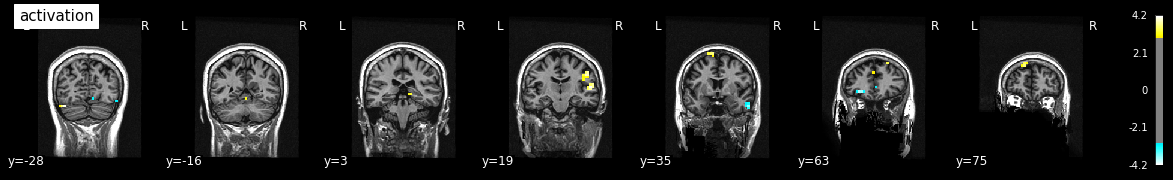

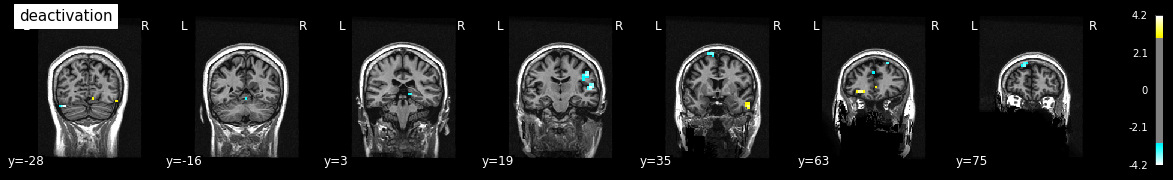

In [86]:
for contrast_id in range(1, len(test_to_number.keys())+1):
    plot_stat_map(
        f'/output/datasink/1stLevel/sub-{subject_id}/spmT_000{contrast_id}.nii', title=test_to_number[contrast_id],
        bg_img=anatimg, threshold=3, display_mode='y', dim=-1);


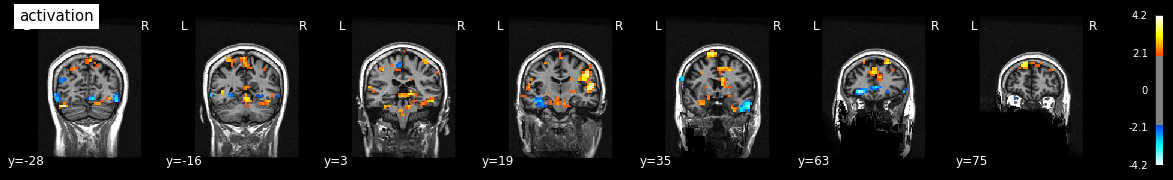

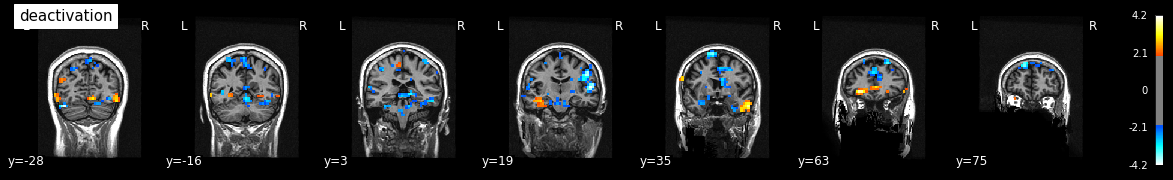

In [101]:
for contrast_id in range(1, len(test_to_number.keys())+1):
    plot_stat_map(
        f'/output/datasink/1stLevel/sub-{subject_id}/spmT_000{contrast_id}.nii', title=test_to_number[contrast_id],
        bg_img=anatimg, threshold=2, display_mode='y', dim=-1);


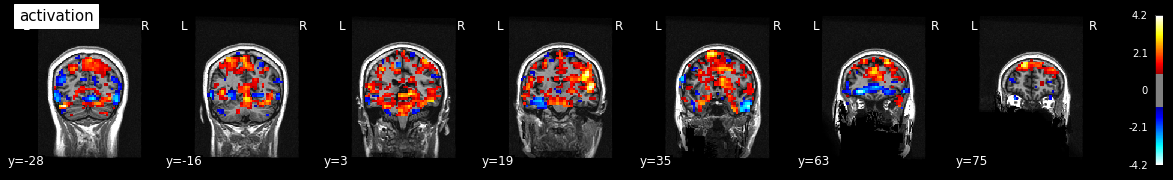

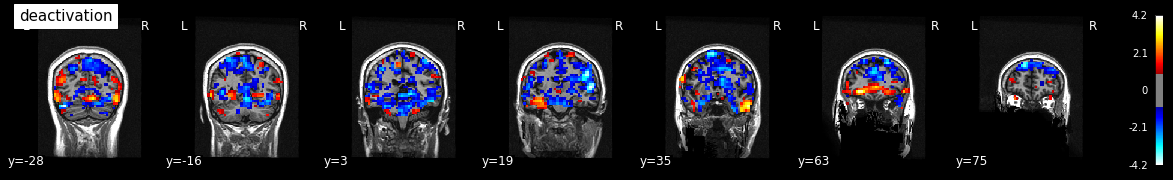

In [85]:
for contrast_id in range(1, len(test_to_number.keys())+1):
    plot_stat_map(
        f'/output/datasink/1stLevel/sub-{subject_id}/spmT_000{contrast_id}.nii', title=test_to_number[contrast_id],
        bg_img=anatimg, threshold=1, display_mode='y', dim=-1);


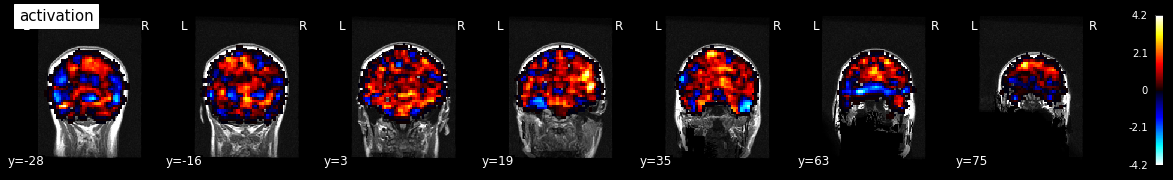

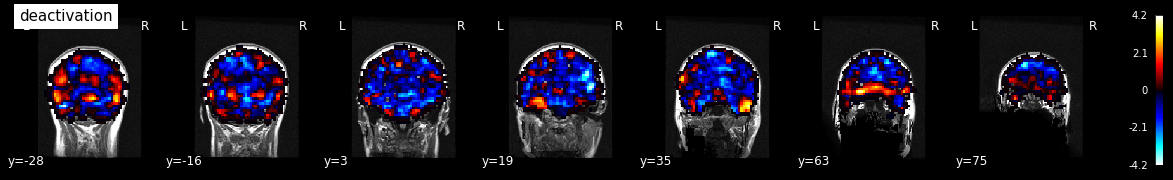

In [84]:
for contrast_id in range(1, len(test_to_number.keys())+1):
    plot_stat_map(
        f'/output/datasink/1stLevel/sub-{subject_id}/spmT_000{contrast_id}.nii', title=test_to_number[contrast_id],
        bg_img=anatimg, threshold=.01, display_mode='y', dim=-1);


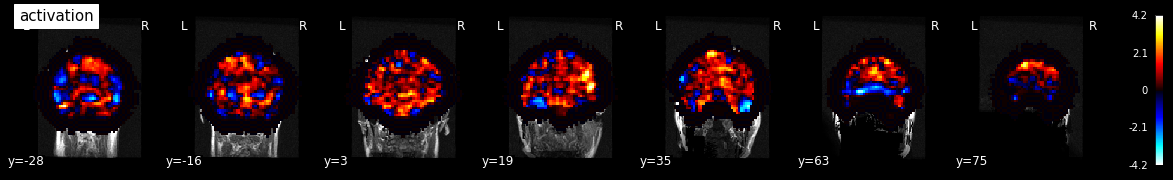

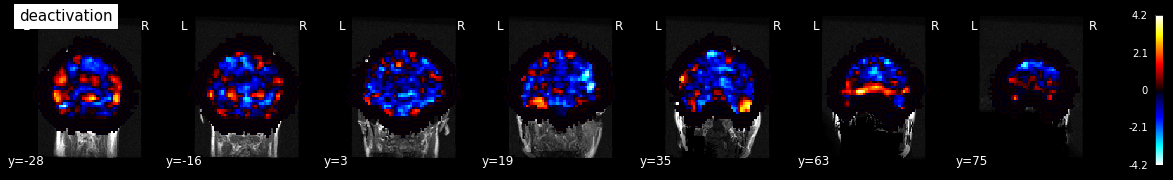

In [89]:
for contrast_id in range(1, len(test_to_number.keys())+1):
    plot_stat_map(
        f'/output/datasink/1stLevel/sub-{subject_id}/spmT_000{contrast_id}.nii', title=test_to_number[contrast_id],
        bg_img=anatimg, threshold='auto', display_mode='y', dim=-1);


**Report:**
So here we produced a statistical map for fMRI data of verb generation experiment. To estimate this map we follow the steps:


* Firstly, we create a general linear model from our preprocessed fMRI timeseries and design matrix, constructed from regressors of interest. This regressors of interest are timeseries that represent a brain respond to a particular task or they might be some noise estimates like motion drift. In our case this design matrix is a single column as we have only one task performed and we did some preprocessing to minimize the influence of motion drift. Also, when we create this design matrix from our data we make time adjustements due to deleted fMRI volumes during the preprocessing -- we extracted regions of interest in the first part of HW and specified to skip 4 dummies, each TR time long.
* Secondly, we decide on what hypothesises we want to test on the dataset, which reflect our suggestions on what events cause a response in each voxel compared to rest. In our case, we test a whether a hypothesis that there is a response during a task in each voxel (\betta_1 is non-zero) is statisticaly significant.
* Finally, we wrap all data processing and testing from two previous steps into a Nipype graph and this way apply it to each voxel so that in the end we receive a statistical map for the whole brain.  


By analysing this map, we can tell on some peculiarities of brain activity of a subject when performing a task. For example, in the last section of this HW we visualized these maps for subject #01. I did two t-test which mirror each other so we can ignore second row in each visualized set and analize only first one. By applying `plot_stat_map` with different thresholds we can higlight voxels of the brain map that with statistical significance (equal to threshold) respond to the performed task. So, applying weak/low threshold in this case is useless because we will see that a lot of voxels are highlighted however we can be less sure that they have a reaction to the performed task. We can choose this threshold with some guarantees on the level of false positive rate like it is shown in [this](https://nilearn.github.io/stable/auto_examples/00_tutorials/plot_single_subject_single_run.html#plot-thresholded-z-scores-map) example from `nilearn`. We can see for threshold=2 that the largest active area can be found on the right part of the brain on the top of the head, y=19. However, other slices show localization in other brain regions what means that the activity is not limited to one particular brain part. 


**Sources:**


[General Linear Model for Neuroimaging](https://www.fmrib.ox.ac.uk/primers/appendices/glm.pdf)

[Convolution](https://practical-neuroimaging.github.io/on_convolution.html)

[General Linear Model (GLM)](http://mriquestions.com/general-linear-model.html)


**Special thanks to Michael Notter for the wonderful [nipype tutorial](https://miykael.github.io/nipype_tutorial/)**